In [80]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(cowplot))
library(grid)
library(aplot)
library(anndata)
library(ggplot2)
library(patchwork)
library(scales)
library(MASS)
library(reshape)
library(metR)
set.seed(42)


Attaching package: ‘metR’


The following object is masked from ‘package:grid’:

    as.path




In [82]:
calculate_density <- function(data, x_col, y_col, n = 100) {
  # Perform kernel density estimation
  density <- kde2d(data[[y_col]], data[[x_col]], n = n)
  
  # Reformat output to get density at each pixel
  density_long_format <- melt(density$z)
  
  # Get coordinates
  x_cord <- rep(density$x, each = n)
  y_cord <- rep(density$y, times = n)
  
  # Assign names to the columns
  names(density_long_format) <- c("x", "y", "z")
  density_long_format$x <- x_cord
  density_long_format$y <- y_cord
  
  return(density_long_format)
}

In [2]:
adata = anndata::read_h5ad('reference/AIFI_Ref_reprocessed.h5ad')

In [222]:
adata

AnnData object with n_obs × n_vars = 1821725 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'well_id', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'sample.visitName', 'sample.drawDate', 'file.id', 'subject.cmv', 'subject.bmi', 'celltypist.low', 'seurat.l1', 'seurat.l1.score', 'seurat.l2', 'seurat.l2.score', 'seurat.l2.5', 'seurat.l2.5.score', 'seurat.l3', 'seurat.l3.score', 'predicted_doublet', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3', 

In [39]:
UMAP_Cord<-adata$obsm['X_umap']$X_umap

In [40]:
meta_data<-adata$obs[c("subject.biologicalSex",'cohort.cohortGuid','subject.cmv')]

In [41]:
combined_matrix <- cbind(UMAP_Cord, meta_data)

In [197]:
random_indices <- sample(1:dim(combined_matrix)[1], 100000, replace = FALSE)
df_subset <- as.data.frame(combined_matrix[random_indices, ])
colnames(df_subset)<-c('UMAP_1','UMAP_2','Sex','Cohort','CMV')

In [215]:
df_Pos<-df_subset %>% filter(Sex=='Male')
df_Neg<-df_subset %>% filter(Sex=='Female')

In [216]:
density_pos<-calculate_density(df_Pos,'UMAP_1','UMAP_2',n=100)
density_neg<-calculate_density(df_Neg,'UMAP_1','UMAP_2',n=100)

In [217]:
density_substraction<-density_pos$z-density_neg$z

In [218]:
density_diff<-cbind(density_pos[c('x','y')],density_pos$z-density_neg$z)
colnames(density_diff)<-c('x','y','z')

In [219]:


lvls <- pretty(range(density_diff$z),20)
lvls <- sort(unique(c(lvls, -lvls)))


In [220]:
color_vector<-rep(c('#b2182b','#ef8a62','#fddbc7','white','#d1e5f0','#67a9cf','#2166ac'), 
                 each = 1)

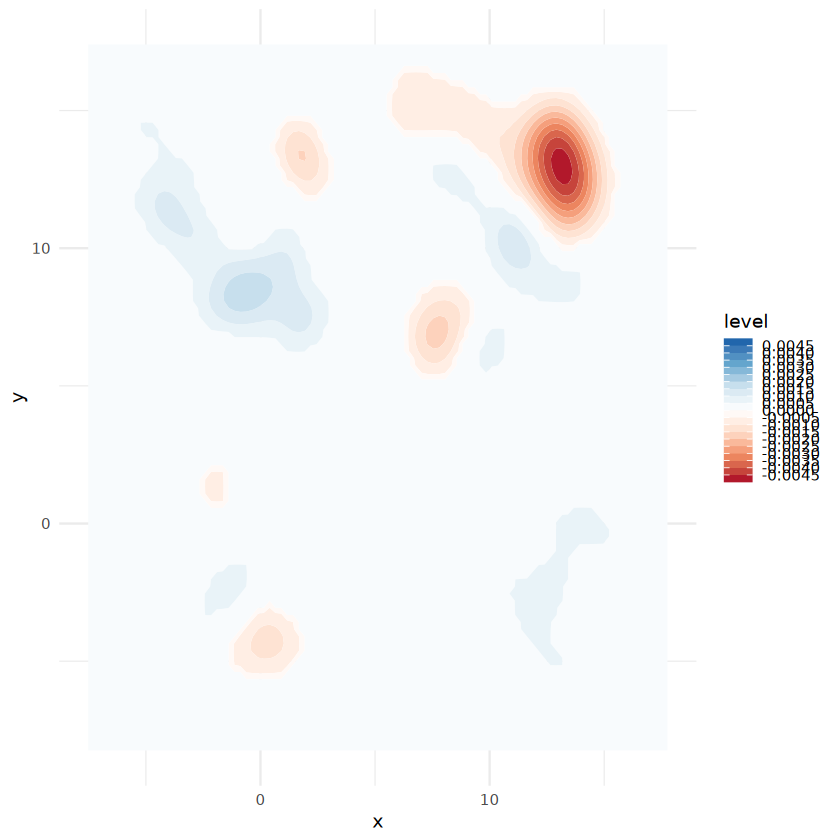

In [221]:
p <- ggplot(density_diff %>% mutate(z=case_when(abs(z)<0.0005~0,TRUE~z)), 
                                    aes(x = x, y = y, z = z)) + 
  geom_contour_filled(aes(fill = after_stat(level)),
                      breaks = lvls) +
  scale_fill_gradientn(
colours =color_vector,
      na.value='white',
    super = metR::ScaleDiscretised) +
theme_minimal()+
  theme(
    plot.background = element_rect(fill = "white", color = 'white'),
    panel.background = element_rect(fill = "white", color = 'white')
  )

print(p)